# Nonsan

In [7]:
%load_ext autoreload
%autoreload
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from matplotlib.colors import LogNorm

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from scipy import stats

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import median_absolute_error
from sklearn.metrics import r2_score

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel

from mlp_regression import mlp_regression, model_validation, mlp_prediction, mlp_prediction_error, errorDist, \
                            mlp_train_multi_graph, mlp_train_multi_graph_comb, mlp_train_multi_3dgraph_comb, \
                            ann_train_graph, mlp_multiple_models_train_graph, build_tf_ann_model, PrintDot, prediction_error
from guassian_process import gp_regression, prediction_rmse_error, gp_train_graph, gp_linear_compare_graph
from utils import combineArray, multiArraySort, data_loader_from_csv, data_loader_pathloss, describeData, data_loader_pathloss_with_freq

pd.set_option('display.max_rows', 999)
pd.set_option('precision', 5)

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Winter: Distance-Pathloss

In [8]:
%autoreload
X_train_m_400, X_test_m_400, y_train_m_400, y_test_m_400, X_train_s_400, X_test_s_400, y_train_s_400, y_test_s_400 = data_loader_from_csv('../data/PLdata_nonsan_wt_400.csv', np.log10(400), 'distance', [0,4], testRatio=0.2, log = True)
X_train_m_1399, X_test_m_1399, y_train_m_1399, y_test_m_1399, X_train_s_1399, X_test_s_1399, y_train_s_1399, y_test_s_1399 = data_loader_from_csv('../data/PLdata_nonsan_wt_1399.csv', np.log10(1399),'distance', [0,4], testRatio=0.2, log = True)
X_train_m_2249, X_test_m_2249, y_train_m_2249, y_test_m_2249, X_train_s_2249, X_test_s_2249, y_train_s_2249, y_test_s_2249 = data_loader_from_csv('../data/PLdata_nonsan_wt_2249.csv', np.log10(2249),'distance', [0,4], testRatio=0.2, log = True)

X_train_m = combineArray(X_train_m_400, X_train_m_1399, X_train_m_2249)
y_train_m = combineArray(y_train_m_400, y_train_m_1399, y_train_m_2249)
X_test_m = combineArray(X_test_m_400, X_test_m_1399, X_test_m_2249)
y_test_m = combineArray(y_test_m_400, y_test_m_1399, y_test_m_2249)

X_train_s = combineArray(X_train_s_400, X_train_s_1399, X_train_s_2249)
y_train_s = combineArray(y_train_s_400, y_train_s_1399, y_train_s_2249)
X_test_s = combineArray(X_test_s_400, X_test_s_1399, X_test_s_2249)
y_test_s = combineArray(y_test_s_400, y_test_s_1399, y_test_s_2249)

dataX_m, dataY_m = [X_train_m_400, X_train_m_1399, X_train_m_2249], [y_train_m_400, y_train_m_1399, y_train_m_2249]
sample_amount = 500

selection_train_400 = np.random.choice(X_train_m_400.shape[0], sample_amount, replace=False)
selection_train_1399 = np.random.choice(X_train_m_1399.shape[0], sample_amount, replace=False)
selection_train_2249 = np.random.choice(X_train_m_2249.shape[0], sample_amount, replace=False)
selection_train = np.random.choice(X_train_m.shape[0], sample_amount, replace=False)

X_train_m_400_sampled = X_train_m_400[selection_train_400]
X_train_m_1399_sampled = X_train_m_1399[selection_train_1399]
X_train_m_2249_sampled = X_train_m_2249[selection_train_2249]
X_train_m_sampled = X_train_m[selection_train]

y_train_m_400_sampled = y_train_m_400[selection_train_400]
y_train_m_1399_sampled = y_train_m_1399[selection_train_1399]
y_train_m_2249_sampled = y_train_m_2249[selection_train_2249]
y_train_m_sampled = y_train_m[selection_train]

selection_test_400 = np.random.choice(X_test_m_400.shape[0], sample_amount, replace=False)
selection_test_1399 = np.random.choice(X_test_m_1399.shape[0], sample_amount, replace=False)
selection_test_2249 = np.random.choice(X_test_m_2249.shape[0], sample_amount, replace=False)
selection_test = np.random.choice(X_test_m.shape[0], sample_amount, replace=False)

X_test_m_400_sampled = X_test_m_400[selection_test_400]
X_test_m_1399_sampled = X_test_m_1399[selection_test_1399]
X_test_m_2249_sampled = X_test_m_2249[selection_test_2249]
X_test_m_sampled = X_test_m[selection_test]

y_test_m_400_sampled = y_test_m_400[selection_test_400]
y_test_m_1399_sampled = y_test_m_1399[selection_test_1399]
y_test_m_2249_sampled = y_test_m_2249[selection_test_2249]
y_test_m_sampled = y_test_m[selection_test]

dataX_m_sampled, dataY_m_sampled = [X_train_m_400_sampled, X_train_m_1399_sampled, X_train_m_2249_sampled], [y_train_m_400_sampled, y_train_m_1399_sampled, y_train_m_2249_sampled]

original: 114545
filtered: 29735
- moving type: total: 23394 (training: 18715/validation: 4679)
- stationary type: total: 6341 (training: 5072/validation: 1269)
original: 114455
filtered: 29645
- moving type: total: 23304 (training: 18643/validation: 4661)
- stationary type: total: 6341 (training: 5072/validation: 1269)
original: 114341
filtered: 29531
- moving type: total: 23190 (training: 18552/validation: 4638)
- stationary type: total: 6341 (training: 5072/validation: 1269)


PL_0_400: 55.40230589574203


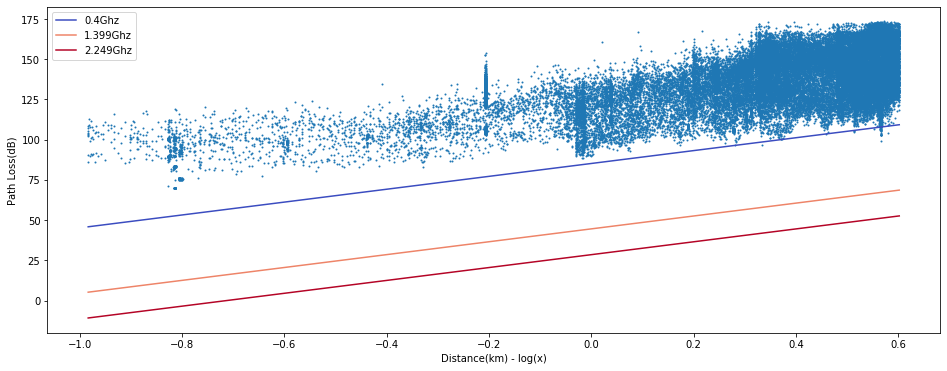

In [20]:
#lambda = 0.6667, 0.2069, 0.1304
h_t = 0.015
h_r = 0.002
lamb400, lamb1399, lamb2249 = 0.6667, 0.2069, 0.1304
d_c400, d_c1399, d_c2249 = 0.180, 0.580, 0.920

PL_0_400 = 20*np.log10(np.square(lamb400) // (8*np.pi*h_t*h_r))
PL_0_1399 = 20*np.log10(lamb1399**2 / (8*np.pi*h_t*h_r))
PL_0_2249 = 20*np.log10(lamb2249**2 / (8*np.pi*h_t*h_r))
print("PL_0_400:",PL_0_400)
PL_400_train = PL_0_400 + 40*(X_train_m_400[:,0] - np.log10(d_c400))
PL_1399_train = PL_0_1399 + 40*(X_train_m_1399[:,0] - np.log10(d_c1399))
PL_2249_train = PL_0_2249 + 40*(X_train_m_2249[:,0] - np.log10(d_c2249))
PL_train_dataset = [PL_400_train, PL_1399_train, PL_2249_train]

mlp_train_multi_graph(dataX_m, dataY_m, PL_train_dataset, X_train_m[:,0], y_train_m, 'distance')

# PL_400_test = PL_0_400 + 40*(X_test_m_400 - np.log10(d_c400))
# PL_1399_test = PL_0_1399 + 40*(X_test_m_1399 - np.log10(d_c1399))
# PL_2249_test = PL_0_2249 + 40*(X_test_m_2249 - np.log10(d_c2249))

# stat = np.array([modelprediction_error(linear_400_model,X_test_m_400, y_test_m_400),mean_absolute_error(y_test_m_400, pred_test_400),mean_absolute_percentage_error(y_test_m_400, pred_test_400),mean_squared_log_error(y_test_m_400, pred_test_400),r2_score(y_test_m_400, pred_test_400),
#                  mlp_prediction_error(linear_1399_model,X_test_m_1399, y_test_m_1399),mean_absolute_error(y_test_m_1399, pred_test_1399),mean_absolute_percentage_error(y_test_m_1399, pred_test_1399),mean_squared_log_error(y_test_m_1399, pred_test_1399),r2_score(y_test_m_1399, pred_test_1399),
#                  mlp_prediction_error(linear_2249_model,X_test_m_2249, y_test_m_2249),mean_absolute_error(y_test_m_2249, pred_test_2249),mean_absolute_percentage_error(y_test_m_2249, pred_test_2249),mean_squared_log_error(y_test_m_2249, pred_test_2249),r2_score(y_test_m_2249, pred_test_2249)])

# (pd.DataFrame(stat.reshape((3,5)),index=pd.Index(['0.4Ghz','1.399Ghz','2.249Ghz']), columns=pd.Index(['RMSE','MAE','MAPE','MSLE','R2'],name='TEST ERROR(dB)')))

<Paju - Winter> Linear (dist<=6000m)


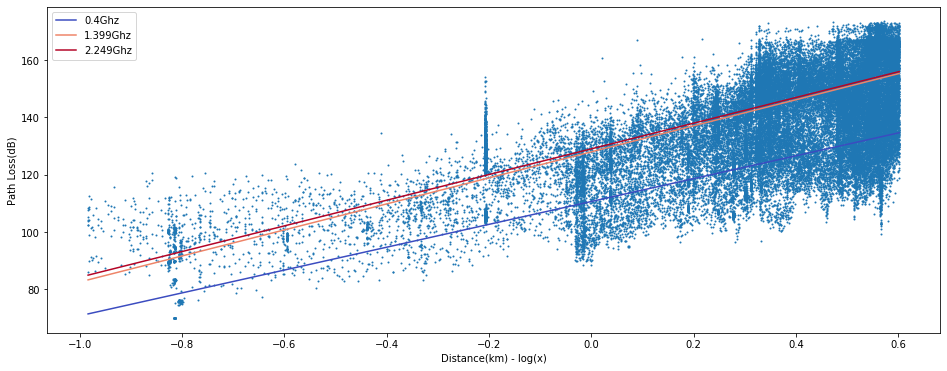

TEST ERROR(dB),RMSE,MAE,MAPE,MSLE,R2
0.4Ghz,8.89426,7.14252,5.88293,0.00524,0.58418
1.399Ghz,10.89076,8.50747,6.18730,0.00620,0.55141
2.249Ghz,10.14755,7.98361,5.69444,0.00520,0.56585
Overall,10.24067,8.09612,6.07778,0.00580,0.66975


In [3]:
%autoreload
linear_400_model = LinearRegression().fit(X_train_m_400, y_train_m_400)
linear_1399_model = LinearRegression().fit(X_train_m_1399, y_train_m_1399)
linear_2249_model = LinearRegression().fit(X_train_m_2249, y_train_m_2249)
linear_over_model = LinearRegression().fit(X_train_m, y_train_m)

print("<Paju - Winter> Linear (dist<=6000m)")
# mlp_train_multi_3dgraph_comb(ann_relu_model, dataX_m, dataY_m, X_train_m, ['0.4', '1.399','2.249'])

pred_train_400 = linear_400_model.predict(X_train_m_400)
pred_train_1399 = linear_1399_model.predict(X_train_m_1399)
pred_train_2249 = linear_2249_model.predict(X_train_m_2249)
pred_train_dataset = [pred_train_400, pred_train_1399, pred_train_2249]

mlp_train_multi_graph(dataX_m, dataY_m, pred_train_dataset, X_train_m[:,0], y_train_m, 'distance')

pred_test_400 = linear_400_model.predict(X_test_m_400)
pred_test_1399 = linear_1399_model.predict(X_test_m_1399)
pred_test_2249 = linear_2249_model.predict(X_test_m_2249)

pred_test_m = linear_over_model.predict(X_test_m)
stat = np.array([mlp_prediction_error(linear_400_model,X_test_m_400, y_test_m_400),mean_absolute_error(y_test_m_400, pred_test_400),mean_absolute_percentage_error(y_test_m_400, pred_test_400),mean_squared_log_error(y_test_m_400, pred_test_400),r2_score(y_test_m_400, pred_test_400),
                 mlp_prediction_error(linear_1399_model,X_test_m_1399, y_test_m_1399),mean_absolute_error(y_test_m_1399, pred_test_1399),mean_absolute_percentage_error(y_test_m_1399, pred_test_1399),mean_squared_log_error(y_test_m_1399, pred_test_1399),r2_score(y_test_m_1399, pred_test_1399),
                 mlp_prediction_error(linear_2249_model,X_test_m_2249, y_test_m_2249),mean_absolute_error(y_test_m_2249, pred_test_2249),mean_absolute_percentage_error(y_test_m_2249, pred_test_2249),mean_squared_log_error(y_test_m_2249, pred_test_2249),r2_score(y_test_m_2249, pred_test_2249),
                 mlp_prediction_error(linear_over_model,X_test_m, y_test_m), mean_absolute_error(y_test_m, pred_test_m),mean_absolute_percentage_error(y_test_m, pred_test_m),mean_squared_log_error(y_test_m, pred_test_m),r2_score(y_test_m, pred_test_m)])

(pd.DataFrame(stat.reshape((4,5)),index=pd.Index(['0.4Ghz','1.399Ghz','2.249Ghz', 'Overall']), columns=pd.Index(['RMSE','MAE','MAPE','MSLE','R2'],name='TEST ERROR(dB)')))

<Paju - Winter> ANN-Sigmoid (dist<=6000m)


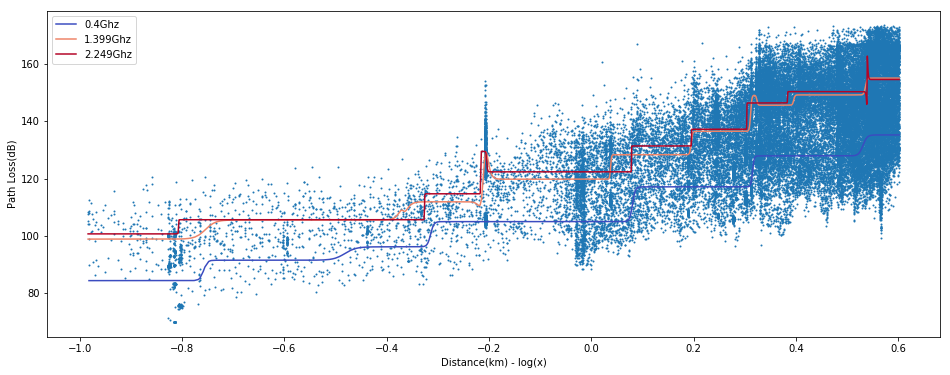

TEST ERROR(dB),RMSE,MAE,MAPE,MSLE,R2
0.4Ghz,8.57937,6.56645,5.37264,0.00478,0.62917
1.399Ghz,10.15287,7.76842,5.55970,0.00517,0.62212
2.249Ghz,9.20486,7.25715,5.12755,0.00417,0.63710
Overall,9.38513,7.25999,5.39843,0.00475,0.72923


In [8]:
%autoreload
ann_400_model = mlp_regression(X_train_m_400, y_train_m_400, (60,), 'logistic', 'lbfgs')
ann_1399_model = mlp_regression(X_train_m_1399, y_train_m_1399, (60,), 'logistic', 'lbfgs')
ann_2249_model = mlp_regression(X_train_m_2249, y_train_m_2249, (60,), 'logistic', 'lbfgs')
ann_over_model = mlp_regression(X_train_m, y_train_m, (60,), 'logistic', 'lbfgs')

print("<Paju - Winter> ANN-Sigmoid (dist<=6000m)")
# mlp_train_multi_3dgraph_comb(ann_relu_model, dataX_m, dataY_m, X_train_m, ['0.4', '1.399','2.249'])

pred_train_400 = ann_400_model.predict(X_train_m_400)
pred_train_1399 = ann_1399_model.predict(X_train_m_1399)
pred_train_2249 = ann_2249_model.predict(X_train_m_2249)
pred_train_dataset = [pred_train_400, pred_train_1399, pred_train_2249]

mlp_train_multi_graph(dataX_m, dataY_m, pred_train_dataset, X_train_m[:,0], y_train_m, 'distance')

pred_test_400 = ann_400_model.predict(X_test_m_400)
pred_test_1399 = ann_1399_model.predict(X_test_m_1399)
pred_test_2249 = ann_2249_model.predict(X_test_m_2249)
pred_test_m = ann_over_model.predict(X_test_m)

stat = np.array([mlp_prediction_error(ann_400_model,X_test_m_400, y_test_m_400),mean_absolute_error(y_test_m_400, pred_test_400),mean_absolute_percentage_error(y_test_m_400, pred_test_400),mean_squared_log_error(y_test_m_400, pred_test_400),r2_score(y_test_m_400, pred_test_400),
                 mlp_prediction_error(ann_1399_model,X_test_m_1399, y_test_m_1399),mean_absolute_error(y_test_m_1399, pred_test_1399),mean_absolute_percentage_error(y_test_m_1399, pred_test_1399),mean_squared_log_error(y_test_m_1399, pred_test_1399),r2_score(y_test_m_1399, pred_test_1399),
                 mlp_prediction_error(ann_2249_model,X_test_m_2249, y_test_m_2249),mean_absolute_error(y_test_m_2249, pred_test_2249),mean_absolute_percentage_error(y_test_m_2249, pred_test_2249),mean_squared_log_error(y_test_m_2249, pred_test_2249),r2_score(y_test_m_2249, pred_test_2249),
                 mlp_prediction_error(ann_over_model,X_test_m, y_test_m), mean_absolute_error(y_test_m, pred_test_m),mean_absolute_percentage_error(y_test_m, pred_test_m),mean_squared_log_error(y_test_m, pred_test_m),r2_score(y_test_m, pred_test_m)])

(pd.DataFrame(stat.reshape((4,5)),index=pd.Index(['0.4Ghz','1.399Ghz','2.249Ghz', 'Overall']), columns=pd.Index(['RMSE','MAE','MAPE','MSLE','R2'],name='TEST ERROR(dB)')))

<Paju - Winter> Gaussian Process (dist<=6000m)


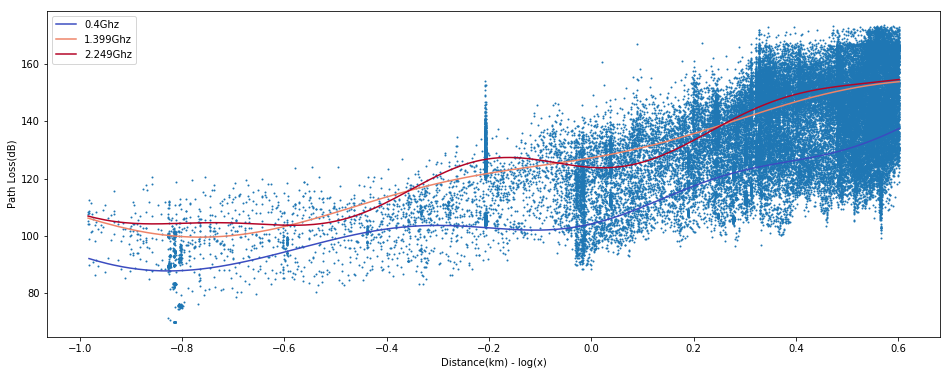

TEST ERROR(dB),RMSE,MAE,MAPE,R2
0.4Ghz,8.86153,7.04353,5.77664,0.60437
1.399Ghz,10.74120,8.40553,6.06096,0.57706
2.249Ghz,9.62174,7.62716,5.40840,0.60349
Overall,9.89895,7.84421,5.85546,0.69878


In [5]:
%autoreload
kernel = 'RBF'

gp_rbf_400_model = gp_regression(kernel).fit(X_train_m_400_sampled, y_train_m_400_sampled)
gp_rbf_1399_model = gp_regression(kernel).fit(X_train_m_1399_sampled, y_train_m_1399_sampled)
gp_rbf_2249_model = gp_regression(kernel).fit(X_train_m_2249_sampled, y_train_m_2249_sampled)
gp_rbf_over_model = gp_regression(kernel).fit(X_train_m_sampled, y_train_m_sampled)

print("<Paju - Winter> Gaussian Process (dist<=6000m)")
# mlp_train_multi_3dgraph_comb(ann_relu_model, dataX_m, dataY_m, X_train_m, ['0.4', '1.399','2.249'])

pred_train_400, std_400 = gp_rbf_400_model.predict(X_train_m_400, return_std=True)
pred_train_1399, std_1399 = gp_rbf_1399_model.predict(X_train_m_1399, return_std=True)
pred_train_2249, std_2249 = gp_rbf_2249_model.predict(X_train_m_2249, return_std=True)

pred_train_dataset = [pred_train_400, pred_train_1399, pred_train_2249]
data_std = [std_400, std_1399, std_2249]

mlp_train_multi_graph(dataX_m, dataY_m, pred_train_dataset, X_train_m[:,0], y_train_m, 'distance')

pred_test_400 = gp_rbf_400_model.predict(X_test_m_400)
pred_test_1399 = gp_rbf_1399_model.predict(X_test_m_1399)
pred_test_2249 = gp_rbf_2249_model.predict(X_test_m_2249)
pred_test_m = gp_rbf_over_model.predict(X_test_m)

stat = np.array([mlp_prediction_error(gp_rbf_400_model,X_test_m_400, y_test_m_400),mean_absolute_error(y_test_m_400, pred_test_400),mean_absolute_percentage_error(y_test_m_400, pred_test_400),r2_score(y_test_m_400, pred_test_400),
                 mlp_prediction_error(gp_rbf_1399_model,X_test_m_1399, y_test_m_1399),mean_absolute_error(y_test_m_1399, pred_test_1399),mean_absolute_percentage_error(y_test_m_1399, pred_test_1399),r2_score(y_test_m_1399, pred_test_1399),
                 mlp_prediction_error(gp_rbf_2249_model,X_test_m_2249, y_test_m_2249),mean_absolute_error(y_test_m_2249, pred_test_2249),mean_absolute_percentage_error(y_test_m_2249, pred_test_2249),r2_score(y_test_m_2249, pred_test_2249),
                 mlp_prediction_error(gp_rbf_over_model,X_test_m, y_test_m), mean_absolute_error(y_test_m, pred_test_m),mean_absolute_percentage_error(y_test_m, pred_test_m),r2_score(y_test_m, pred_test_m)])

(pd.DataFrame(stat.reshape((4,4)),index=pd.Index(['0.4Ghz','1.399Ghz','2.249Ghz', 'Overall']), columns=pd.Index(['RMSE','MAE','MAPE','R2'],name='TEST ERROR(dB)')))

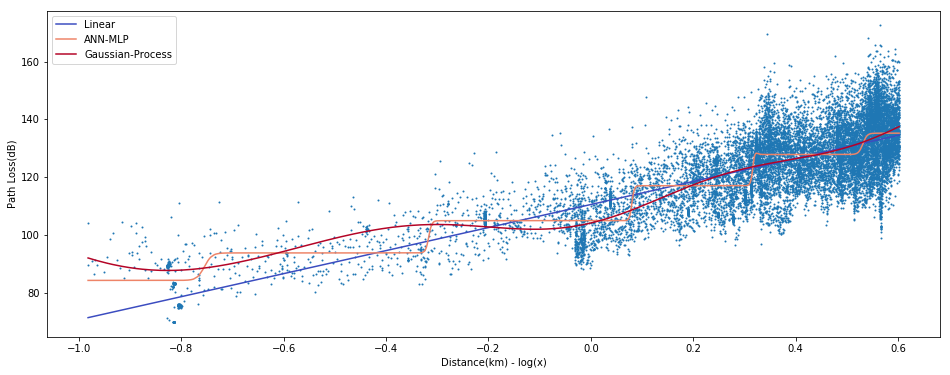

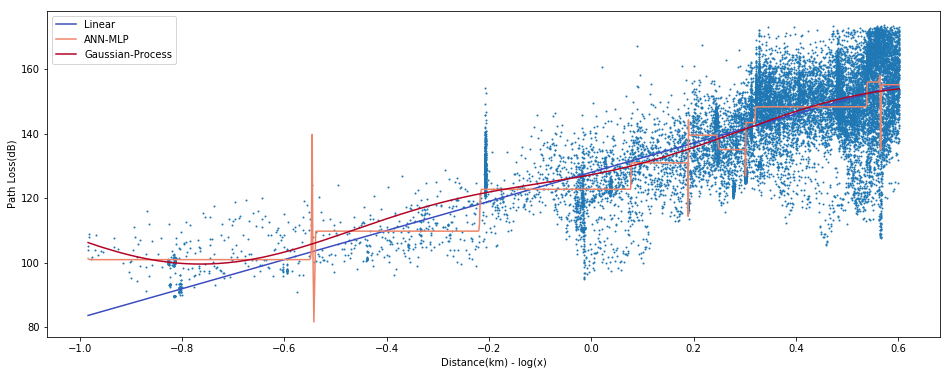

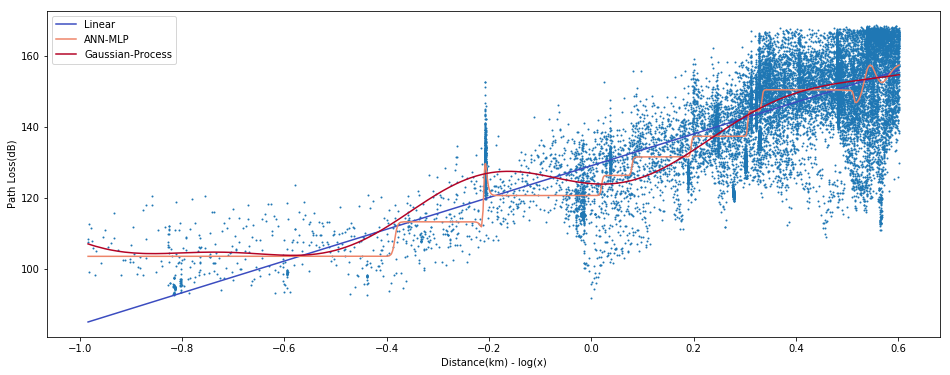

In [6]:
%autoreload
models = [linear_400_model, ann_400_model, gp_rbf_400_model]
mlp_multiple_models_train_graph(models, X_train_m_400, y_train_m_400)
models = [linear_1399_model, ann_1399_model, gp_rbf_1399_model]
mlp_multiple_models_train_graph(models, X_train_m_1399, y_train_m_1399)
models = [linear_2249_model, ann_2249_model, gp_rbf_2249_model]
mlp_multiple_models_train_graph(models, X_train_m_2249, y_train_m_2249)

<Paju - Winter> ANN-Sigmoid (dist<=6000m)
27.641130572837795


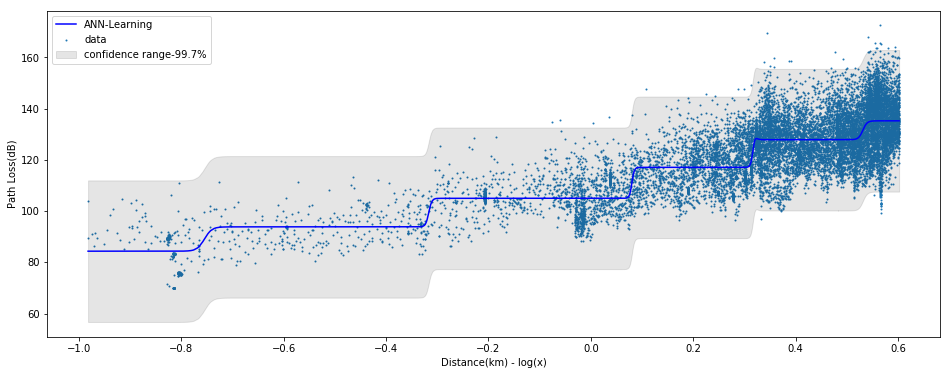

30.18496331611848


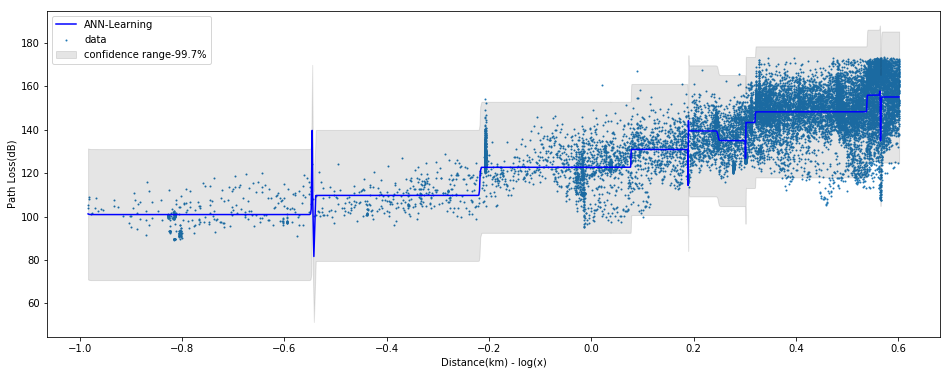

29.005172225841925


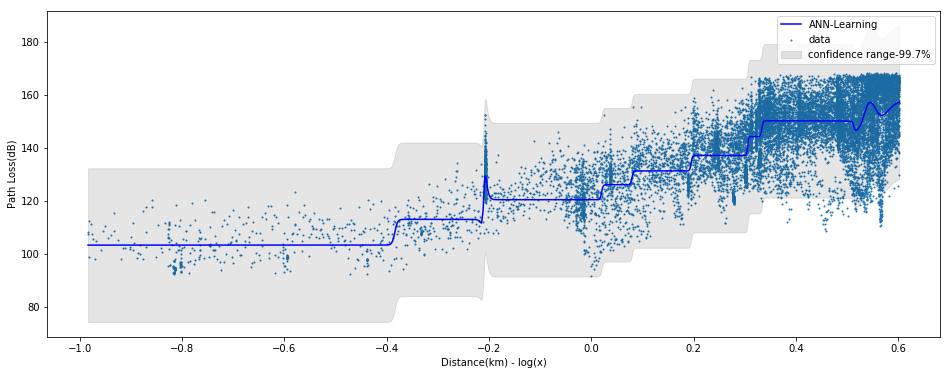

In [7]:
%autoreload
print("<Paju - Winter> ANN-Sigmoid (dist<=6000m)")
# mlp_train_multi_3dgraph_comb(ann_relu_model, dataX_m, dataY_m, X_train_m, ['0.4', '1.399','2.249'])
muliplier = 3
pred_train_400 = ann_400_model.predict(X_train_m_400).flatten()
pred_train_1399 = ann_1399_model.predict(X_train_m_1399).flatten()
pred_train_2249 = ann_2249_model.predict(X_train_m_2249).flatten()

pred_train_dataset = [pred_train_400, pred_train_1399, pred_train_2249]
data_std = [muliplier*std_400.mean(), muliplier*std_1399.mean(), muliplier*std_2249.mean()]

ann_train_graph(X_train_m_400, y_train_m_400, pred_train_400, X_train_m_400[:,0], y_train_m_400, True, muliplier*std_400.mean())
ann_train_graph(X_train_m_1399, y_train_m_1399, pred_train_1399, X_train_m_1399[:,0], y_train_m_1399, True, muliplier*std_1399.mean())
ann_train_graph(X_train_m_2249, y_train_m_2249, pred_train_2249, X_train_m_2249[:,0], y_train_m_2249, True, muliplier*std_2249.mean())